In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from src.utils import preprocess_cscid
from src.data import read_data, setup_paths, get_data_basic_matches
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# read full data
paths = setup_paths()
df_full = pd.read_parquet(os.path.join(paths['out_data'], 'nway_csc21_gaia3_full.parquet'))

# get basic matches (positives and negatives)
separation_threshold = 1.3 
range_offaxis = '0-3'

df_pos, df_neg = get_data_basic_matches(df_full, range_offaxis, separation_threshold)

# split chandra ids into train/val splits
cscids = df_pos.csc21_name.unique()
cscids_train, cscids_val = train_test_split(cscids, test_size=0.2, random_state=42)

df_analysis = pd.concat([df_pos, df_neg])

# create train/val sets
train_set = df_analysis[df_analysis['csc21_name'].isin(cscids_train)]
val_set = df_analysis[df_analysis['csc21_name'].isin(cscids_val)]


Range 0-3: 30279 positives, 310020 negatives


In [2]:
dw_df = pd.read_parquet('../data/nway_CSC21_GAIA3.parquet', engine='fastparquet')
dw_df['CSC21_CSCID'] = dw_df['CSC21_CSCID'].str.replace('_', ' ').str.rstrip()
dw_df['GAIA3_source_id'] = dw_df['GAIA3_source_id'].str.rstrip()

In [3]:
# Rename columns in dw_df to match naming convention
dw_df = dw_df.rename(columns={
    'GAIA3_source_id': 'gaia3_source_id',
    'CSC21_CSCID': 'csc21_name'
})

# Create matched dataframes
dw_df_pos = pd.merge(
    df_pos,
    dw_df,
    on=['gaia3_source_id', 'csc21_name'],
    how='inner'
)

dw_df_neg = pd.merge(
    df_neg,
    dw_df,
    on=['gaia3_source_id', 'csc21_name'],
    how='inner'
)

print(f"Positive matches: {len(dw_df_pos)}")
print(f"Negative matches: {len(dw_df_neg)}")

# Plot configurations remain the same as before...

Positive matches: 30279
Negative matches: 310020


In [4]:
# read vot to pandas ../data/all_stacks.vot
from astropy.io.votable import parse_single_table

# read vot to pandas
table = parse_single_table('../data/all_stacks.vot')

# recover column names
df_all_stacks = table.to_table().to_pandas()
df_all_stacks.columns = [col.name for col in table.fields]

In [5]:
# Get unique CSC IDs from positive matches
unique_pos_cscids = dw_df_pos['csc21_name'].unique()

# Merge with all_stacks data
stacks_pos = pd.merge(
    df_all_stacks,
    pd.DataFrame({'csc21_name': unique_pos_cscids}),
    left_on='name',
    right_on='csc21_name',
    how='inner'
)

# Count stacks starting with 'hrc'
hrc_count = stacks_pos['detect_stack_id'].str.startswith('hrc').sum()
total_count = len(stacks_pos)

print(f"Total unique positive matches: {len(unique_pos_cscids)}")
print(f"Total stacks found: {total_count}")
print(f"HRC stacks: {hrc_count} ({hrc_count/total_count*100:.1f}%)")

# Get CSCIDs with only HRC stacks
hrc_only_mask = stacks_pos.groupby('csc21_name')['detect_stack_id'].apply(
    lambda x: all(id.startswith('hrc') for id in x)
)
hrc_only_cscids = hrc_only_mask[hrc_only_mask].index

print(f"CSCIDs with only HRC stacks: {len(hrc_only_cscids)} ({len(hrc_only_cscids)/len(unique_pos_cscids)*100:.1f}%)")

Total unique positive matches: 30279
Total stacks found: 39442
HRC stacks: 1043 (2.6%)
CSCIDs with only HRC stacks: 249 (0.8%)


In [5]:
# What we need is epos1 := sqrt(era1^2 + ede1^2), and similarly for epos2.  (Assuming era are in arcsec and the cos(dec) factor is accounted for.)  And then of course epos = sqrt(epos1^2 + epos2^2).

# Calculate the positional error for the positive matches
dw_df_pos['new_epos1'] = np.sqrt(dw_df_pos['csc21_errmaj']**2 + dw_df_pos['csc21_errmin']**2)
dw_df_pos['new_epos2'] = np.sqrt(dw_df_pos['gaia3_era']**2 + dw_df_pos['gaia3_edec']**2)
dw_df_pos['new_epos'] = np.sqrt(dw_df_pos['new_epos1']**2 + dw_df_pos['new_epos2']**2)

# Calculate the positional error for the negative matches
dw_df_neg['new_epos1'] = np.sqrt(dw_df_neg['csc21_errmaj']**2 + dw_df_neg['csc21_errmin']**2)
dw_df_neg['new_epos2'] = np.sqrt(dw_df_neg['gaia3_era']**2 + dw_df_neg['gaia3_edec']**2)
dw_df_neg['new_epos'] = np.sqrt(dw_df_neg['new_epos1']**2 + dw_df_neg['new_epos2']**2)

In [24]:
# compute the fraction of  of sources in either set where SEP/new_EPOS >1.7 and >3.4?
sep_pos = (dw_df_pos['separation'] / dw_df_pos['new_epos'])
sep_neg = (dw_df_neg['separation'] / dw_df_neg['new_epos'])

frac_pos_17 = (sep_pos > 1.7).sum() / len(sep_pos)
frac_pos_34 = (sep_pos > 3.4).sum() / len(sep_pos)

frac_neg_17 = (sep_neg > 1.7).sum() / len(sep_neg)
frac_neg_34 = (sep_neg > 3.4).sum() / len(sep_neg)

print(f"Positive matches:")
print(f"Fraction of sources with SEP/new_EPOS > 1.7: {frac_pos_17:.2f}")
print(f"Fraction of sources with SEP/new_EPOS > 3.4: {frac_pos_34:.2f}")

print(f"Negative matches:")
print(f"Fraction of sources with SEP/new_EPOS > 1.7: {frac_neg_17:.2f}")
print(f"Fraction of sources with SEP/new_EPOS > 3.4: {frac_neg_34:.2f}")

Positive matches:
Fraction of sources with SEP/new_EPOS > 1.7: 0.04
Fraction of sources with SEP/new_EPOS > 3.4: 0.00
Negative matches:
Fraction of sources with SEP/new_EPOS > 1.7: 1.00
Fraction of sources with SEP/new_EPOS > 3.4: 1.00


In [9]:
max(sep_pos)

NameError: name 'sep_pos' is not defined

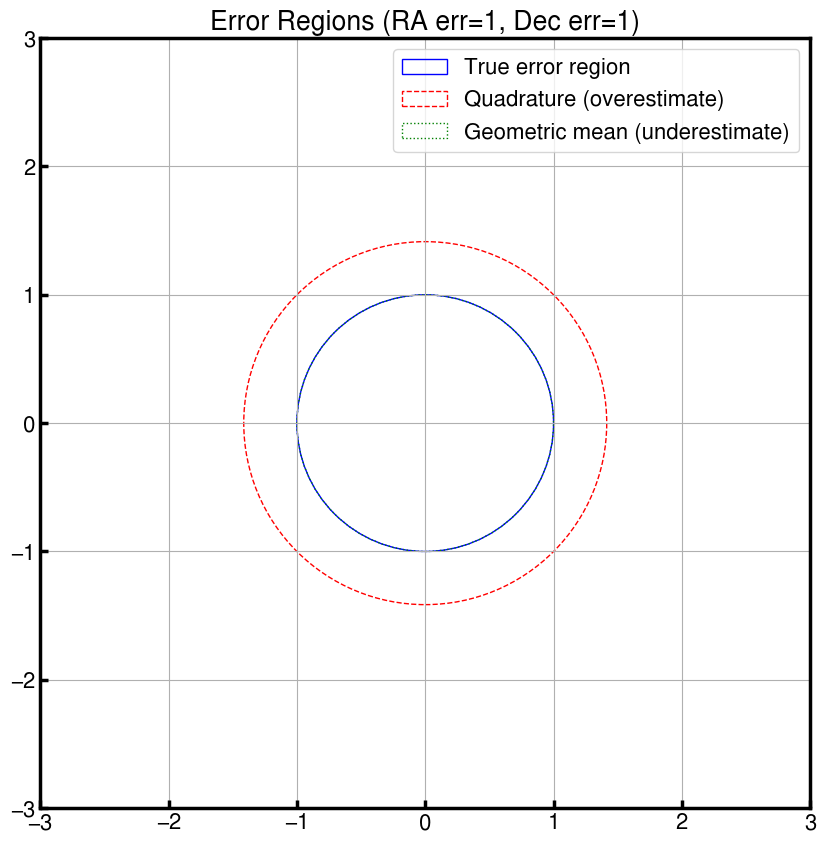

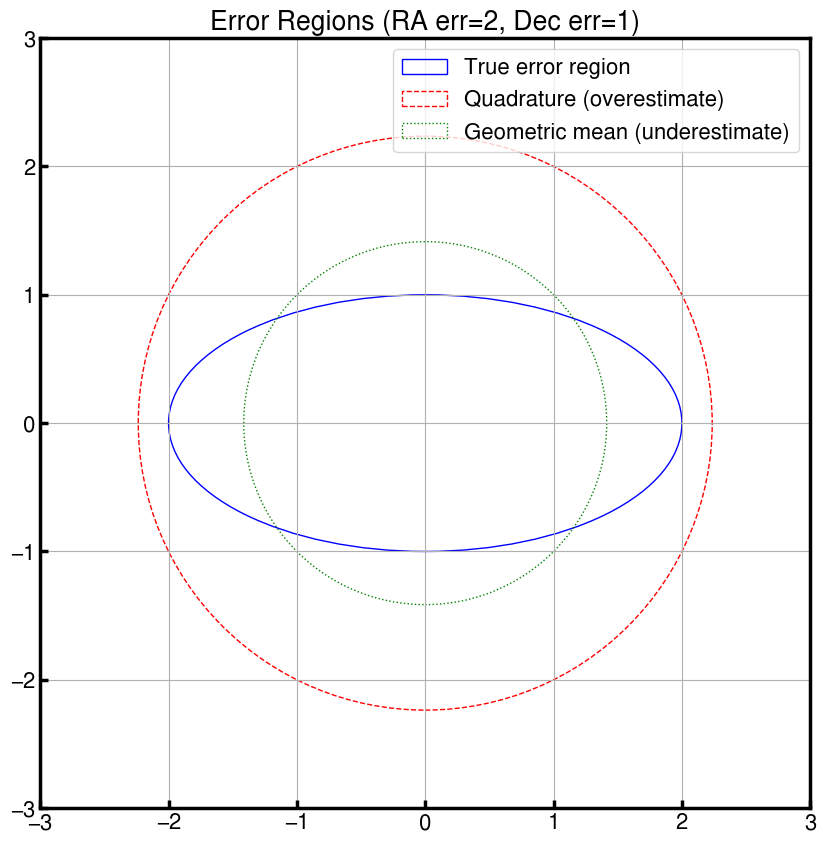

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_error_regions(era, edec):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create error ellipse
    ellipse = Ellipse((0, 0), 2*era, 2*edec, 
                      facecolor='none', edgecolor='blue', label='True error region')
    ax.add_patch(ellipse)
    
    # Plot the different uncertainty estimates
    circle_quad = plt.Circle((0, 0), np.sqrt(era**2 + edec**2), 
                           facecolor='none', edgecolor='red', 
                           linestyle='--', label='Quadrature (overestimate)')
    circle_geom = plt.Circle((0, 0), np.sqrt(era * edec),
                           facecolor='none', edgecolor='green',
                           linestyle=':', label='Geometric mean (underestimate)')
    
    ax.add_patch(circle_quad)
    ax.add_patch(circle_geom)
    
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend()
    plt.title(f'Error Regions (RA err={era}, Dec err={edec})')
    
# Plot for equal and unequal uncertainties
plot_error_regions(1, 1)  # Equal errors
plt.figure(1)
plot_error_regions(2, 1)  # Elongated error region
plt.figure(2)
plt.show()

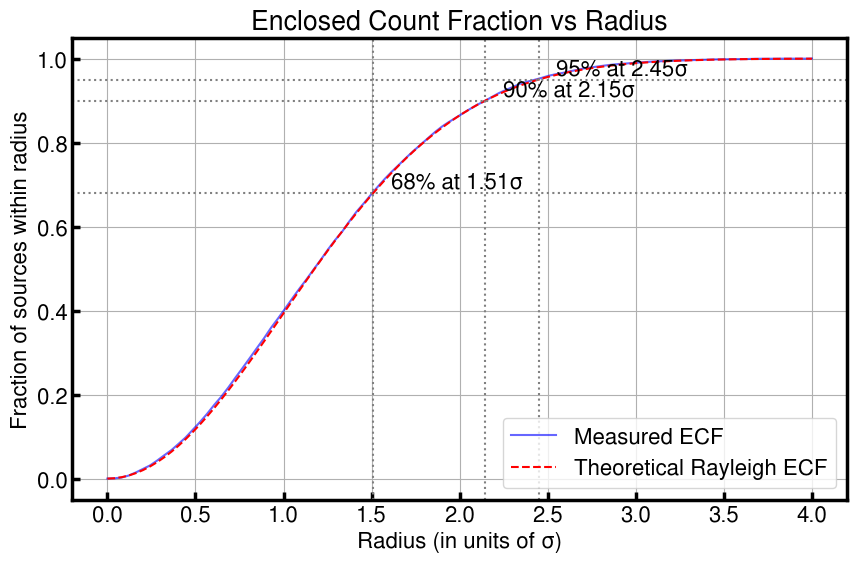

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, rayleigh

# Generate data
n_points = 10000
err = 1.0
measured_ra = np.random.normal(0, err, n_points)
measured_dec = np.random.normal(0, err, n_points)
r = np.sqrt(measured_ra**2 + measured_dec**2)

# Calculate ECF at different radii
radii = np.linspace(0, 4*err, 100)
ecf_data = [np.mean(r <= radius) for radius in radii]

# Theoretical ECF for Rayleigh distribution
ecf_theory = 1 - np.exp(-0.5*(radii/err)**2)

plt.figure(figsize=(10,6))

# Plot ECF
plt.plot(radii, ecf_data, 'b-', alpha=0.6, label='Measured ECF')
plt.plot(radii, ecf_theory, 'r--', label='Theoretical Rayleigh ECF')

# Add some key percentiles
for p in [0.68, 0.90, 0.95]:
   r_cut = err * np.sqrt(-2*np.log(1-p))
   plt.axhline(y=p, color='gray', linestyle=':')
   plt.axvline(x=r_cut, color='gray', linestyle=':')
   plt.text(r_cut+0.1, p, f'{p*100:.0f}% at {r_cut:.2f}σ', 
            verticalalignment='bottom')

plt.xlabel('Radius (in units of σ)')
plt.ylabel('Fraction of sources within radius')
plt.title('Enclosed Count Fraction vs Radius')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
# Case where RA error = Dec error = 1 arcsec
ra_err = dec_err = 1.0

# Quadrature method (what Vinay suggests)
quad_error = np.sqrt(ra_err * dec_err)  # = 1.414 arcsec

# True circular error (what Dong-Woo points out)
true_error = ra_err  # = 1.0 arcsec

print(f"For equal RA/Dec errors of {ra_err} arcsec:")
print(f"Quadrature gives {quad_error:.3f} arcsec")
print(f"True circular error is {true_error:.3f} arcsec")
print(f"Overestimation factor: {quad_error/true_error:.3f}x")

For equal RA/Dec errors of 1.0 arcsec:
Quadrature gives 1.000 arcsec
True circular error is 1.000 arcsec
Overestimation factor: 1.000x


In [17]:
# # What we need is epos1 := sqrt(era1^2 + ede1^2), and similarly for epos2.  (Assuming era are in arcsec and the cos(dec) factor is accounted for.)  And then of course epos = sqrt(epos1^2 + epos2^2).
# calculate new_epos for whole file, save a unique row for each chandra ID with their respective epos values and save it as a csv file
dw_df['new_epos1'] = np.sqrt(dw_df['CSC21_Errmaj']**2 + dw_df['CSC21_Errmin']**2)
dw_df['new_epos2'] = np.sqrt(dw_df['GAIA3_era']**2 + dw_df['GAIA3_edec']**2)
dw_df['new_epos'] = np.sqrt(dw_df['new_epos1']**2 + dw_df['new_epos2']**2)

dw_df_unique = dw_df[['ENS', 'csc21_name', 'gaia3_source_id', 'new_epos1', 'new_epos2', 'new_epos']]

dw_df_unique.to_csv('outputs/epos_values.csv', index=False)

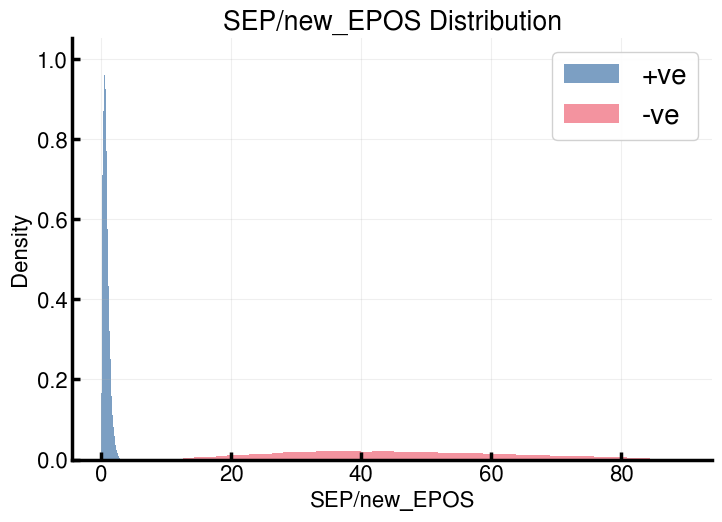

In [22]:
# set plot parameters
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 16 
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 2.5
plt.rcParams['ytick.major.width'] = 2.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6

# create figure
fig, ax = plt.subplots(figsize=(7.5, 5.5))

# plot histograms
ax.hist(dw_df_pos['separation']/dw_df_pos['new_epos'], bins=50, density=True, alpha=0.7, 
        color='#4477AA', label='+ve')
ax.hist(dw_df_neg['separation']/dw_df_neg['new_epos'], bins=50, density=True, alpha=0.7,
       color='#EE6677', label='-ve')

# customize plot
ax.set_xlabel('SEP/new_EPOS')
ax.set_ylabel('Density')
ax.set_title('SEP/new_EPOS Distribution')

# formatting
ax.grid(True, alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=True, framealpha=0.9, fontsize=20)

plt.tight_layout()
plt.show()